# Description

- This is an analysis notebook

## Features

## todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import json
import copy
import traceback

import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
from log_parser import process_file, process_file_jasper



# parameters

In [4]:
_fname = "../replays/local.log"
# _fname = "../replays/day1-log15.log"
# _fname = "../replays/day3-log1.log"
_time_step = 100
_max_time = 3000000
_symbols = ["BANANAS", "PEARLS", "COCONUTS", "PINA_COLADAS", "BERRIES", "DIVING_GEAR"]
_products = ["BANANAS", "PEARLS", "COCONUTS", "PINA_COLADAS", "BERRIES", "DIVING_GEAR"]

print("_fname", _fname)


_fname ../replays/local.log


# pre processing

In [5]:
# load data from file

obj = process_file(_fname, start_sep="__game_state_start", end_sep="__game_state_end")

raw_df = pd.DataFrame(obj)

listings = pd.DataFrame(raw_df["listings"][0])
# products = set(listings.T["product"])
raw_df = raw_df.drop("listings", axis=1)
raw_df = raw_df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_df["time"])
print("num missing_times", len(missing_times))
print("missing_times", sorted(missing_times))


Reading from input file ../replays/local.log
num missing_times 0
missing_times []


In [6]:
# load order info from file
obj = process_file(_fname, start_sep="__turn_end_start", end_sep="__turn_end_end")
raw_records = pd.DataFrame(obj)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_records["time"])
print("num missing_times", len(missing_times))
print("missing_times", sorted(missing_times))

Reading from input file ../replays/local.log
num missing_times 0
missing_times []


In [7]:
# finish turns
display(raw_df[["finish_turn"]].T)

,0,1,2,3,4,5,6,7,8,9,...,29990,29991,29992,29993,29994,29995,29996,29997,29998,29999
finish_turn,-1,0,1,2,3,4,5,6,7,8,...,29989,29990,29991,29992,29993,29994,29995,29996,29997,29998


### total runtime

In [8]:
# show total runtime of program
display(raw_records[["wall_time", "process_time"]].sum().to_frame())

display(raw_records[["wall_time", "process_time"]].max().to_frame())

,0
wall_time,44.366641
process_time,43.619924


,0
wall_time,0.065154
process_time,0.007229


### add turns

In [9]:
# add turns (vs time)

all_times = raw_df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
raw_df["turn"] = raw_df["time"].map(time2turn_map)

raw_df.index = raw_df["turn"]

### ref_stat_df
- the EMA values that were calculated during the program
- quote_mids during program
- fair valeus calculated during program

In [10]:
# ref_emas contains EMA values that were used during the program
ref_emas = raw_records["best_emas"].apply(pd.Series).round(2)
ref_emas = pd.concat([ref_emas, raw_records["time"]], axis=1)

ref_ema_df = ref_emas.melt(id_vars=["time"], var_name="symbol", value_name="ref_ema") \
                        .sort_values(by=["time", "symbol"]) \
                        .reset_index(drop=True)


In [11]:
# large_quote_mid
quote_mids = raw_records["quote_mids"].apply(pd.Series)
quote_mids = pd.concat([quote_mids, raw_records["time"]], axis=1)

quote_mid_df = quote_mids.melt(id_vars=["time"], var_name="symbol", value_name="quote_mid") \
                        .sort_values(by=["time", "symbol"]) \
                        .reset_index(drop=True)


# large_quote_mid
use_quote_mids = raw_records["use_quote_mids"].apply(pd.Series)
use_quote_mids = pd.concat([use_quote_mids, raw_records["time"]], axis=1)

use_quote_mid_df = use_quote_mids.melt(id_vars=["time"], var_name="symbol", value_name="use_quote_mid") \
                        .sort_values(by=["time", "symbol"]) \
                        .reset_index(drop=True)



In [12]:
fair_values = raw_records["fair_values"].apply(pd.Series)
fair_values = pd.concat([fair_values, raw_records["time"]], axis=1)

fair_value_df = fair_values.melt(id_vars=["time"], var_name="symbol", value_name="fair_value") \
                        .sort_values(by=["time", "symbol"]) \
                        .reset_index(drop=True)


In [13]:
ref_stat_df = pd.concat([
    ref_ema_df.set_index(["time", "symbol"]),
    quote_mid_df.set_index(["time", "symbol"]),
    use_quote_mid_df.set_index(["time", "symbol"]),
    fair_value_df.set_index(["time", "symbol"]),
], axis=1).reset_index()

### book_tops

#### modify raw_df["book"] to be all ints

In [14]:
# modify raw_df["book"] to be all ints
raw_df["book"] = raw_df["book"].apply(lambda x: {
    sym: {
        typ: {
            int(k) : v for k, v in orders.items()
        }
        for typ, orders in all_orders.items()
    }
    for sym, all_orders in x.items()
})

In [15]:
book_data = []
book_cols = []

cmp = lambda k : tuple([int(k[0]), int(k[1])])

for sym in _symbols:
    ### buys
    col = raw_df["book"].apply(lambda x: x[sym])
    # convert dicts into int -> int
    col = col.apply(lambda x : [(int(k), v) for k, v in x["buy_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=True))
    col = col.apply(lambda x : x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_buy"]
    
    
    ### sells
    col = raw_df["book"].apply(lambda x: x[sym])
    col = col.apply(lambda x : [(int(k), v) for k, v in x["sell_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=False))
    col = col.apply(lambda x: x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_sell"]
    
    
book_tops = pd.concat(book_data, axis=1)
book_tops.columns = book_cols

# all book tops
for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    
    print("missing mids", sym, list(book_tops.index[book_tops[f"{sym}_mid"].isna()]))
    
    book_tops[f"{sym}_mid"] = book_tops[f"{sym}_mid"].bfill()
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)
book_tops["time"] = raw_df["time"]



missing mids BANANAS []
missing mids PEARLS []
missing mids COCONUTS []
missing mids PINA_COLADAS []
missing mids BERRIES []
missing mids DIVING_GEAR []


In [16]:
num_data_dropna = len(book_tops.dropna())
num_data = len(book_tops)

print(f"Orig count: {num_data}")
print(f"Remaining count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 30000
Remaining count: 30000
nan count: 0


In [17]:
book_tops

,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,BERRIES_best_buy,BERRIES_best_sell,BERRIES_mid,BERRIES_spread,COCONUTS_best_buy,COCONUTS_best_sell,...,DIVING_GEAR_spread,PEARLS_best_buy,PEARLS_best_sell,PEARLS_mid,PEARLS_spread,PINA_COLADAS_best_buy,PINA_COLADAS_best_sell,PINA_COLADAS_mid,PINA_COLADAS_spread,time
turn,,,,,,,,,,,,,,,,,,,,,
0,4893.0,4899.0,4896.0,6.0,3997.0,4003.0,4000.0,6.0,8113.0,8116.0,...,2.0,9998.0,10005.0,10001.5,7.0,15225.0,15228.0,15226.5,3.0,0
1,4892.0,4896.0,4894.0,4.0,3996.0,4003.0,3999.5,7.0,8113.0,8115.0,...,2.0,9996.0,10002.0,9999.0,6.0,15223.0,15226.0,15224.5,3.0,100
2,4892.0,4899.0,4895.5,7.0,3995.0,4002.0,3998.5,7.0,8113.0,8116.0,...,1.0,9996.0,10004.0,10000.0,8.0,15226.0,15227.0,15226.5,1.0,200
3,4893.0,4899.0,4896.0,6.0,3995.0,4002.0,3998.5,7.0,8113.0,8115.0,...,2.0,9996.0,9998.0,9997.0,2.0,15224.0,15227.0,15225.5,3.0,300
4,4894.0,4899.0,4896.5,5.0,3996.0,4003.0,3999.5,7.0,8112.0,8114.0,...,3.0,9998.0,10004.0,10001.0,6.0,15220.0,15223.0,15221.5,3.0,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,4791.0,4798.0,4794.5,7.0,3904.0,3907.0,3905.5,3.0,7909.0,7911.0,...,3.0,9995.0,10005.0,10000.0,10.0,14842.0,14845.0,14843.5,3.0,2999500
29996,4792.0,4793.0,4792.5,1.0,3904.0,3911.0,3907.5,7.0,7909.0,7912.0,...,2.0,9995.0,10002.0,9998.5,7.0,14844.0,14847.0,14845.5,3.0,2999600
29997,4792.0,4799.0,4795.5,7.0,3904.0,3911.0,3907.5,7.0,7910.0,7913.0,...,3.0,9995.0,9998.0,9996.5,3.0,14844.0,14847.0,14845.5,3.0,2999700


In [18]:
def report_issue_and_continue(condition, fail_msg):
    try:
        assert condition
    except:
        traceback.print_exc()
        display(fail_msg)

### func - flatten_trades() + mark my trades

In [19]:
def flatten_trades(raw_df, col, is_me):
    # get market trades

    data = []
    for index, row  in raw_df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    # print(df.columns)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_buy"] = df["buyer"] == "SUBMISSION"
    df["my_sell"] = df["seller"] == "SUBMISSION"
    df["my_quantity"] = df["quantity"] * (df["my_buy"].astype(int) - df["my_sell"].astype(int))
    df["self_trade"] = df["my_buy"] & df["my_sell"]
    
    # report self trades
    self_trades = df[df["self_trade"]]
    report_issue_and_continue( len(self_trades) == 0, self_trades)
    
    return df

In [20]:
my_trades = flatten_trades(
    raw_df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")

Traceback (most recent call last):
  File "/var/folders/fv/6rc0c0r11hn6xpyhsr9z6rrc0000gn/T/ipykernel_58671/1382268830.py", line 3, in report_issue_and_continue
    assert condition
AssertionError


,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade
1,SUBMISSION,100000,50,SUBMISSION,DIVING_GEAR,0,100,1,True,True,True,0,True
4,SUBMISSION,100000,50,SUBMISSION,DIVING_GEAR,100,200,2,True,True,True,0,True
8,SUBMISSION,100002,48,SUBMISSION,DIVING_GEAR,200,300,3,True,True,True,0,True
11,SUBMISSION,100000,48,SUBMISSION,DIVING_GEAR,300,400,4,True,True,True,0,True
20,SUBMISSION,99986,48,SUBMISSION,DIVING_GEAR,700,800,8,True,True,True,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27919,SUBMISSION,100124,1,SUBMISSION,DIVING_GEAR,2994500,2994600,29946,True,True,True,0,True
27920,SUBMISSION,100122,1,SUBMISSION,DIVING_GEAR,2994700,2994800,29948,True,True,True,0,True
27922,SUBMISSION,100120,1,SUBMISSION,DIVING_GEAR,2994900,2995000,29950,True,True,True,0,True
27923,SUBMISSION,100112,1,SUBMISSION,DIVING_GEAR,2995000,2995100,29951,True,True,True,0,True


### dup trade filtering -> market_trades, my_trades, trade_df

In [21]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    raw_df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    raw_df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")

""" start of filtering """

market_trades = market_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])
# my_trades = my_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])


# ## old filter methods
# # filter market trades (only keep those where order_time = fill_time)
# market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# filter my_trades (only keep those where fill_time = order_time + 100)
my_trades = my_trades[my_trades["time"] <= my_trades["order_time"] + _time_step]
# end of old filter methods

""" end of filtering """

trade_df = pd.concat([market_trades, my_trades])

sum_cols = ["quantity", "my_quantity"]

# aggregate quantity over similar trades
trade_df = trade_df.groupby(list(set(trade_df.columns) - set(sum_cols)))[sum_cols].sum().reset_index()[trade_df.columns]
trade_df = trade_df.sort_values(by=["time", "symbol"]).reset_index(drop=True)


# sort by time
trade_df = trade_df.sort_values(by="time").reset_index(drop=True)

# add ref_stats to trade_df
trade_df = trade_df.merge(ref_stat_df, left_on=["order_time", "symbol"], right_on=["time", "symbol"], suffixes=(None, "_ignore"))
trade_df = trade_df.drop("time_ignore", axis=1)
trade_df["buy_edge"] = trade_df["fair_value"] - trade_df["price"]

my_trades = trade_df[trade_df["is_me"]].copy()
market_trades = trade_df[~trade_df["is_me"]].copy()



Traceback (most recent call last):
  File "/var/folders/fv/6rc0c0r11hn6xpyhsr9z6rrc0000gn/T/ipykernel_58671/1382268830.py", line 3, in report_issue_and_continue
    assert condition
AssertionError


,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade
1,SUBMISSION,100000,50,SUBMISSION,DIVING_GEAR,0,100,1,True,True,True,0,True
4,SUBMISSION,100000,50,SUBMISSION,DIVING_GEAR,100,200,2,True,True,True,0,True
8,SUBMISSION,100002,48,SUBMISSION,DIVING_GEAR,200,300,3,True,True,True,0,True
11,SUBMISSION,100000,48,SUBMISSION,DIVING_GEAR,300,400,4,True,True,True,0,True
20,SUBMISSION,99986,48,SUBMISSION,DIVING_GEAR,700,800,8,True,True,True,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27919,SUBMISSION,100124,1,SUBMISSION,DIVING_GEAR,2994500,2994600,29946,True,True,True,0,True
27920,SUBMISSION,100122,1,SUBMISSION,DIVING_GEAR,2994700,2994800,29948,True,True,True,0,True
27922,SUBMISSION,100120,1,SUBMISSION,DIVING_GEAR,2994900,2995000,29950,True,True,True,0,True
27923,SUBMISSION,100112,1,SUBMISSION,DIVING_GEAR,2995000,2995100,29951,True,True,True,0,True


### volume summary

In [22]:
for sym in _symbols:
    print(sym)
    
    my_sym_trades = my_trades[my_trades["symbol"] == sym]
    my_volume = my_sym_trades["quantity"].abs().sum()
    market_sym_trades = market_trades[market_trades["symbol"] == sym]
    market_volume = market_sym_trades["quantity"].abs().sum()
    
    my_vol_perc = my_volume / (my_volume + market_volume) * 100
    
    print("[THEM]\t count:", len(market_sym_trades), "\tvolume:", market_volume)
    print("[MY]\t count:", len(my_sym_trades), "\tvolume:", my_volume)
    print(f"[MY]\t vol%: {round(my_vol_perc, 2)}%")

BANANAS
[THEM]	 count: 356 	volume: 1650
[MY]	 count: 6957 	volume: 16550
[MY]	 vol%: 90.93%
PEARLS
[THEM]	 count: 141 	volume: 308
[MY]	 count: 6631 	volume: 16120
[MY]	 vol%: 98.13%
COCONUTS
[THEM]	 count: 2 	volume: 24
[MY]	 count: 403 	volume: 29186
[MY]	 vol%: 99.92%
PINA_COLADAS
[THEM]	 count: 0 	volume: 0
[MY]	 count: 403 	volume: 19450
[MY]	 vol%: 100.0%
BERRIES
[THEM]	 count: 143 	volume: 971
[MY]	 count: 1729 	volume: 11280
[MY]	 vol%: 92.07%
DIVING_GEAR
[THEM]	 count: 55 	volume: 76
[MY]	 count: 11453 	volume: 100830
[MY]	 vol%: 99.92%


### my_position validation

In [23]:
# get my_positions
my_positions = pd.DataFrame(list(raw_df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0

# add time/turn to my_positions, sort positions by time
my_positions[["time", "turn"]] = raw_df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
fixed_pos_data = []
cur_pos_data = []
cur_positions = { prod: 0 for prod in _products }
for sym in _symbols:
    cur_positions[f"{sym}_cash"] = 0
fixed_positions = copy.deepcopy(cur_positions)

# init cur_turn
cur_turn = 0

def record_pos_data(cur_positions, fixed_positions, cur_turn, cur_pos_data, fixed_pos_data):
    """
    For a given 'cur_turn', records the positions (calculated from my trades)
    
    """
    
    global my_positions
    
    # copy orig pos
    cur_pos_data += [copy.deepcopy(cur_positions)]
    
    # fix positions if necessary
    cur_time = turn2time_map[cur_turn]
        
    ### init fixed_positions for this turn
    
    # loop through all products
    for prod in _products:
        # look at difference between expected position, and actual "fixed_position"
        diff = my_positions[prod][cur_turn] - fixed_positions[prod]
        price = book_tops[f"{prod}_mid"][cur_turn]
        
        # report this issue
        if diff != 0:
            print(f"[Fixed trade] Turn: {cur_turn}, time: {cur_time}, {prod} {diff} @ {price}")
            
        # fix the position 
        fixed_positions[prod] += diff
        fixed_positions[f"{prod}_cash"] += -1 * diff * price

    # copy fixed pos
    fixed_pos_data += [copy.deepcopy(fixed_positions)]


# sort my_trades
my_trades = my_trades.sort_values(by=["time"])
    
# loop through each of our trades
for index, row in my_trades.iterrows():
    # time of current trade
    
    # iterate until right before this trade occurs
    while cur_turn < row["turn"]:
        # record this position data as the "final position" for the times before this trade
        record_pos_data(cur_positions, fixed_positions, cur_turn, cur_pos_data, fixed_pos_data)
        # increment the time
        cur_turn += 1
        
    # this trade's product
    prod = listings[row["symbol"]]["product"]
    
    # update current positions
    cur_positions[f"{prod}_cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[prod] += row["my_quantity"]
    
    # update fixed positions
    fixed_positions[f"{prod}_cash"] += -1 * row["price"] * row["my_quantity"]
    fixed_positions[prod] += row["my_quantity"]

# add for remaining turns
while cur_turn < len(turn2time_map):
    record_pos_data(cur_positions, fixed_positions, cur_turn, cur_pos_data, fixed_pos_data)
    cur_turn += 1

# record this data for the last turn
# record_pos_data(cur_positions, fixed_positions, cur_time, cur_pos_data, fixed_pos_data)



# pos_df contains calculated position data (based on my_trades)
pos_df = pd.DataFrame(fixed_pos_data).sort_index(axis=1)

# calculate total cash by summing all columns
pos_df["total_cash"] = 0
for prod in _products:
    pos_df["total_cash"] = pos_df["total_cash"] + pos_df[f"{prod}_cash"]

# add to my_positions
for prod in ["total", *_products]:
    my_positions[f"{prod}_cash"] = pos_df[f"{prod}_cash"]
my_positions = my_positions.sort_index(axis=1)

# sanity check our positions
for prod in _products:
    bad_inds = my_positions.index[my_positions[prod] != pos_df[prod]]
    if len(bad_inds) > 0:
        print("true pos")
        display(my_positions.loc[bad_inds])
        print("calculated pos")
        display(pos_df.loc[bad_inds])
        assert False, f"Failed check for product: `{prod}`"

### Construct postbook
- Want to see what the world looked like, after we submit our orders

In [24]:
f_buy = lambda x : sorted(list(x.items()), reverse=True)
f_sell = lambda x : sorted(list(x.items()), reverse=False)
f_my_buy = lambda x : sorted([(el["price"], el["quantity"]) for el in x], reverse=True)
f_my_sell = lambda x : sorted([(el["price"], el["quantity"]) for el in x], reverse=False)

book = pd.merge(raw_df[["book", "time"]], raw_records, on="time")
new_book = book[["time"]].copy()

for sym in _symbols:
    new_book[f"{sym}_buys"] = book["book"].apply(lambda x : f_buy(x[sym]["buy_orders"]))
    new_book[f"{sym}_sells"] = book["book"].apply(lambda x : f_sell(x[sym]["sell_orders"]))
    new_book[f"{sym}_my_buys"] = book["my_orders"].apply(lambda x : f_my_buy(x[sym]["buy_orders"]))
    new_book[f"{sym}_my_sells"] = book["my_orders"].apply(lambda x : f_my_sell(x[sym]["sell_orders"]))

book = new_book


In [25]:
def get_postbook_bounds(sym, time, interval):

    # all trades
    the_trades = trade_df[trade_df["symbol"] == sym]
    the_book = book
    
    
    # filter trades
    time_lb = time // interval * interval
    time_ub = time_lb + interval
    
    the_trades = the_trades[(time_lb <= the_trades["time"]) & (the_trades["time"] < time_ub)]
    the_book = the_book[(time_lb <= the_book["time"]) & (the_book["time"] < time_ub)]
    
    
    def flatten(col):
        return [el[0] for l in list(col) for el in l]
    
    # all orders
    market_buys = the_book[f"{sym}_buys"]
    market_sells = the_book[f"{sym}_sells"]
    my_buys = the_book[f"{sym}_my_buys"]
    my_sells = the_book[f"{sym}_my_sells"]
    
    all_prices = [
        # all trades
        the_trades["price"],
        # all orders
        flatten(market_buys),
        flatten(market_sells),
        flatten(my_buys),
        flatten(my_sells),
    ]
    
    xmin = min([min(x) for x in all_prices if len(x) > 0])
    xmax = max([max(x) for x in all_prices if len(x) > 0])
    
#     print("time", time_lb, time_ub)
#     print("xm", xmin, xmax)
    
    return xmin, xmax

In [26]:
def get_book(sym, time):
    bk = book[book["time"] == time]
    
    if len(bk) == 0:
        print(f"No data for {sym} at time {time}")
        return None, None, None, None
    
    buys = bk[f"{sym}_buys"].iloc[0]
    sells = bk[f"{sym}_sells"].iloc[0]
    my_buys = bk[f"{sym}_my_buys"].iloc[0]
    my_sells = bk[f"{sym}_my_sells"].iloc[0]
    
    return buys, sells, my_buys, my_sells


def get_trades(sym, time):
    market_ts = market_trades[(market_trades["symbol"] == sym) & (market_trades["time"] == time)]
    my_ts = my_trades[(my_trades["symbol"] == sym) & (my_trades["time"] == time)]
    
    market_ts = market_ts.groupby(["symbol", "time", "price"])[["quantity"]].sum().reset_index()
    my_ts = my_ts.groupby(["symbol", "time", "price", "my_buy", "my_sell"])[["quantity"]].sum().reset_index()
    
    return market_ts, my_ts


def get_ref_ema(sym, time):
    return ref_emas.set_index("time").loc[time][sym]


def get_fair_value(sym, time):
    return fair_values.set_index("time").loc[time][sym]


def get_position(sym, time):
    return my_positions.set_index("time").loc[time][sym]

def get_use_quote_mid(sym, time):
    val = ref_stat_df[(ref_stat_df["time"] == time) & (ref_stat_df["symbol"] == sym)]["use_quote_mid"]
    assert(len(val) == 1)
    return val.item()


def show_book(sym, 
              time, 
              xmin=None, 
              xmax=None,
              ymin=None, 
              ymax=None,
             ):
        
    # set figsize    
    
    buys, sells, my_buys, my_sells = get_book(sym, time)
    if buys is None:
        return
    market_ts, my_ts = get_trades(sym, time + _time_step)
    ref_ema = get_ref_ema(sym, time)
    fair_value = get_fair_value(sym, time)
    my_pos = get_position(sym, time)
    
    is_use_quote_mid = get_use_quote_mid(sym, time)
    
    # raw my_buys/my_sells
    print(sym, "raw my_buys")
    display(my_buys)
    print(sym, "raw my_sells")
    display(my_sells)
    
    def f(x):
        df = pd.DataFrame(x, columns=["price", "quantity"])
        if len(df) > 0:
            df = df.groupby("price").sum().reset_index()
        return df
    
    buys, sells, my_buys, my_sells = f(buys), f(sells), f(my_buys), f(my_sells)
    
    # make bars have correct sign
    sells["quantity"] *= -1
    my_buys["quantity"] *= -1
    my_ts["quantity"] *= -1
    
    # plot order book
    if len(buys) > 0:
        plt.bar(buys["price"], buys["quantity"], color="green", label="market buy")
    if len(sells) > 0:
        plt.bar(sells["price"], sells["quantity"], color="red", label="market sells")
    
    if len(my_buys) > 0:
        plt.bar(my_buys["price"], my_buys["quantity"], color="blue", label="my buy")
    if len(my_sells) > 0:
        plt.bar(my_sells["price"], my_sells["quantity"], color="orange", label="my sell")
    
    # plot trades
    if len(market_ts) > 0:
        plt.bar(market_ts["price"], market_ts["quantity"], color=(0, 0, 0, 0), label="market trade", 
                hatch="///", edgecolor="black")
        
    if len(my_ts) > 0:
        plt.bar(my_ts["price"], my_ts["quantity"], color=(0, 0, 0, 0), label="my trade",
                hatch="xxx", edgecolor="black")
    
    
    # use log scale
#     plt.yscale('symlog')
    
    ### draw reference lines
    
    
    # set xlim, ylim
    if xmin:
        plt.xlim(xmin=xmin)
    if xmax:
        plt.xlim(xmax=xmax)
    if ymin:
        plt.ylim(bottom=ymin)
    if ymax:
        plt.ylim(top=ymax)
    
    # draw horizontal line at 0 
    plt.axhline(y=0.0, color="black", linestyle='-')
    
    # draw true mid
    if len(buys) > 0 and len(sells) > 0:
        true_mid = (buys["price"][0] + sells["price"][0]) / 2
        plt.axvline(x=true_mid, color="red", linestyle='solid', alpha=0.2)
    
    # draw ref ema
    plt.axvline(x=ref_ema, color="orange", linestyle='dotted')
    
    # draw fair_value
    plt.axvline(x=fair_value, color="black", linestyle='solid')
    
    ema_span = raw_records[raw_records["time"] == time]["best_ema_spans"].iloc[0][sym]
    
    ### general figure settings    
    plt.legend(loc="upper center")
    plt.title(f"{sym} book - Time: {time} - ema_span: {ema_span} - pos: {my_pos} - use_whale: {is_use_quote_mid}")
    
    
    ### print raw info
#     print("fair_value", fair_value)
#     print("ref_ema", ref_ema)
    
#     print("my_pos", my_pos)
    
#     print("market trades")
#     display(market_ts)
#     print("my trades")
#     display(my_ts)
    
#     print("buys")
#     display(buys.T)
#     print("sells")
#     display(sells.T)
#     print("my_buys")
#     display(my_buys.T)
#     print("my_sells")
#     display(my_sells.T)
    
    
def show_book_simple(
        sym,
        time,
        interval,
        # ymin=None,
        # ymax=None,
        ):
    
    xmin, xmax = get_postbook_bounds(sym, time, interval)
    
    
    POS_LIMITS = {
        "BANANAS": (-50, 50),
        "PEARLS": (-50, 50),
        "COCONUTS": (-1250, 300),
        "PINA_COLADAS": (-650, 150),
    }
    
    ymax = max(np.abs(POS_LIMITS[sym]))
    ymin = -ymax
    
    show_book(
        sym, 
        time,
        xmin=xmin - 1,
        xmax=xmax + 1,
        ymin=ymin,
        ymax=ymax,
    )
    
    

In [27]:
def show_book_single(
        sym,
        time=0,
        interval=10000,
        ):
    
    plt.figure(figsize=(15, 6))
    show_book_simple(
        sym,
        time=time,
        interval=interval,
    )
    plt.show()

def show_book_pair(
        sym1,
        sym2,
        time=0,
        interval=10000,
        ):
    
    # setup figsize
    plt.figure(figsize=(15, 10))
    
    plt.subplot(211)
    show_book_simple(
        sym1,
        time=time,
        interval=interval,
    )
    
    plt.subplot(212)
    show_book_simple(
        sym2,
        time=time,
        interval=interval,
    )
    
    plt.tight_layout()
    plt.show()

In [28]:
# hatched areas show trades
# bars show orders

# vertical red solid line - true mid price based on book
# vertical black dotted line - EMA (that the program used)
interact(
    show_book_single,
    sym=_symbols,
    time=(0, _max_time, _time_step),
    interval=10000,
)

interactive(children=(Dropdown(description='sym', options=('BANANAS', 'PEARLS', 'COCONUTS', 'PINA_COLADAS', 'B…

<function __main__.show_book_single(sym, time=0, interval=10000)>

In [29]:
# hatched areas show trades
# bars show orders

# vertical red solid line - true mid price based on book
# vertical black dotted line - EMA (that the program used)
interact(
    show_book_pair,
    sym1="COCONUTS",
    sym2="PINA_COLADAS",
    time=(0, _max_time, _time_step),
    interval=10000,
)

interactive(children=(Text(value='COCONUTS', description='sym1'), Text(value='PINA_COLADAS', description='sym2…

<function __main__.show_book_pair(sym1, sym2, time=0, interval=10000)>

### create order df (market)

In [30]:
# order_data = []

# for side, side_sign in [("buys", 1), ("sells", -1)]:
#     for sym in _symbols:

#         # expand buy orders
#         df = book[f"{sym}_{side}"]
#         df = pd.DataFrame(df.apply(pd.Series))
#         df["time"] = book["time"]

#         # concat columns into array
#         data = [df[[col, "time"]].set_axis(labels=["order", "time"], axis=1) for col in df.columns if col != "time"]

#         # convert array into order df
#         buy_order_df = pd.concat(data).dropna()

        
#         # mark buy/sells
#         buy_order_df["symbol"] = sym
        
#         order_data += [buy_order_df]
        
# # agg all data
# order_df = pd.concat(order_data)

# # expand order into price/quantity
# temp_df = order_df["order"].apply(lambda x : pd.Series(x, index=["price", "quantity"]))
# order_df = pd.concat([order_df, temp_df], axis=1).drop("order", axis=1)

# # sort data
# order_df = order_df.sort_values(by=["time", "price"]).reset_index(drop=True)

# # merge ref_ema into order_df
# order_df = order_df.merge(ref_stat_df, on=["time", "symbol"])

# # edge that a taker would receive
# order_df["taker_edge"] = -1 * np.sign(order_df["quantity"]) * (order_df["fair_value"] - order_df["price"])

# Analysis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

## General summary

### Estimate Fairs

In [31]:
# estimate fairs
fairs = fair_values.set_index("time").reindex(np.arange(0, _max_time, _time_step)) \
            .ffill().bfill().reset_index()


# mid_cols = [col for col in book_tops.columns if "_mid" in col]
# fairs = book_tops[["time", *mid_cols]]
# fairs.columns = fairs.columns.str.strip('_mid')

fairs

,time,BANANAS,BERRIES,COCONUTS,DIVING_GEAR,PEARLS,PINA_COLADAS
0,0,4895.5,4000.5,8114.5,100000.0,10000.00,15226.5
1,100,4895.0,3999.5,8114.5,100000.0,10000.00,15224.5
2,200,4895.5,3998.5,8114.5,100002.0,10000.00,15225.5
3,300,4896.5,3998.5,8114.0,100000.0,10000.00,15225.5
4,400,4896.0,3999.5,8112.5,99994.5,10000.00,15221.5
...,...,...,...,...,...,...,...
29995,2999500,4794.5,3908.0,7909.5,100174.5,10000.00,14844.0
29996,2999600,4795.5,3907.5,7910.5,100171.0,10000.00,14845.5
29997,2999700,4795.5,3907.5,7911.5,100179.5,10000.00,14845.5
29998,2999800,4795.5,3907.5,7912.5,100182.0,10000.00,14849.5


### Estimate PNLs

In [32]:
# estimate pnl
cash_cols = [f"{prod}_cash" for prod in ["total", *_products]]
# cash_cols += [f"{sym}_cash" for sym in _symbols]

for prod in ["total", *_products]:
    my_positions[f"{prod}_pnl"] = my_positions[f"{prod}_cash"]

for prod in _products:
    col = f"{prod}_pnl"
    my_positions[col] += my_positions[prod] * fairs[prod]
    
    col = "total_pnl"
    my_positions[col] += my_positions[prod] * fairs[prod]


#### func -  plot_trades_and_book()

In [33]:
# plot trades
def plot_trades_and_book(
        sym, 
        trade_df, 
        book_df, 
        time_lb=float("-inf"), 
        time_ub=float("inf"), 
        span=21,
        show_mid=False,
        ):
    
    trade_df = trade_df[(time_lb <= trade_df["time"]) & (trade_df["time"] <= time_ub)]
    book_df = book_df[(time_lb <= book_df["time"]) & (book_df["time"] <= time_ub)]
    
    # filter for this symbol only
    plt_df = trade_df
    plt_df = plt_df[plt_df["symbol"] == sym]

    my_buys = plt_df[plt_df["my_quantity"] > 0]
    my_sells = plt_df[plt_df["my_quantity"] < 0]
    their_trades = plt_df[plt_df["my_quantity"] == 0]
    
    
    
    def plot_trades(ax):
        ax.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
        ax.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
        ax.scatter(their_trades["time"], their_trades["price"], c="orange", s=5)
    
    
    book_df = book_df
    
    bids = book_df[f"{sym}_best_buy"]
    asks = book_df[f"{sym}_best_sell"]
    mids = book_df[f"{sym}_mid"]
    smooth_bids = bids.ewm(span=span).mean()
    smooth_asks = asks.ewm(span=span).mean()
    smooth_mids = mids.ewm(span=span).mean()
    
#     plt.figsize(5, 5)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    times = book_df["time"]
    
    # plot book
    ax = axes[0]
    ax.plot(times, bids, c="green", alpha=0.5, linewidth=0.5, label="bid")
    ax.plot(times, asks, c="red", alpha=0.5, linewidth=0.5, label="ask")
    if show_mid:
        ax.plot(times, mids, c="black", alpha=0.25, linewidth=0.5, label="mid")
    ax.set_title(f"Trades and book: {sym}")
    ax.legend()
    plot_trades(ax)
    
    ax = axes[1]
    ax.plot(times, smooth_bids, c="green", alpha=0.5, linewidth=0.5, label="bid")
    ax.plot(times, smooth_asks, c="red", alpha=0.5, linewidth=0.5, label="ask")
    if show_mid:
        ax.plot(times, smooth_mids, c="black", alpha=0.5, linewidth=0.5, label="mid")
    ax.set_title(f"(smooth) Trades and book: {sym}")
    ax.legend()
    plot_trades(ax)

    plt.show()
    

### overall trade/book graph

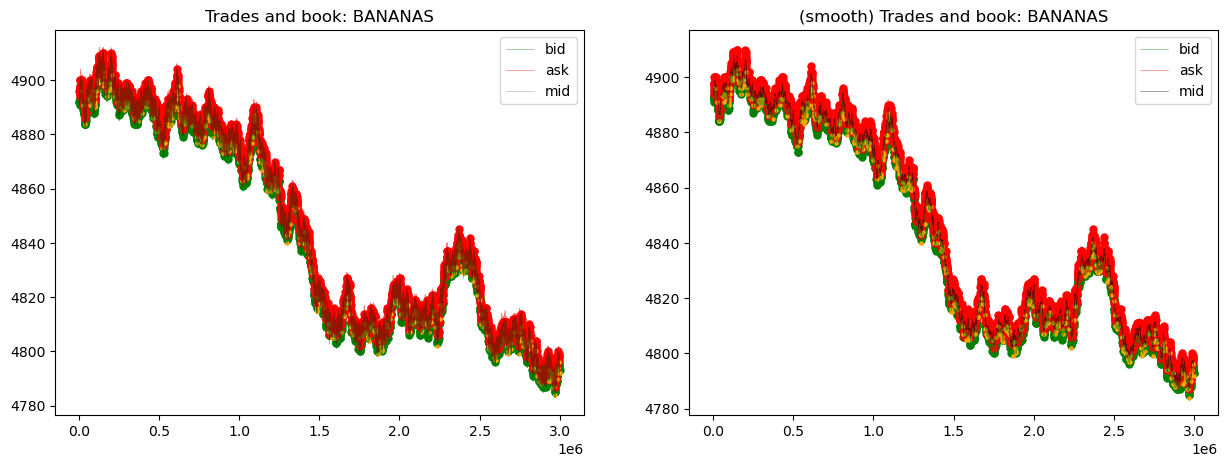

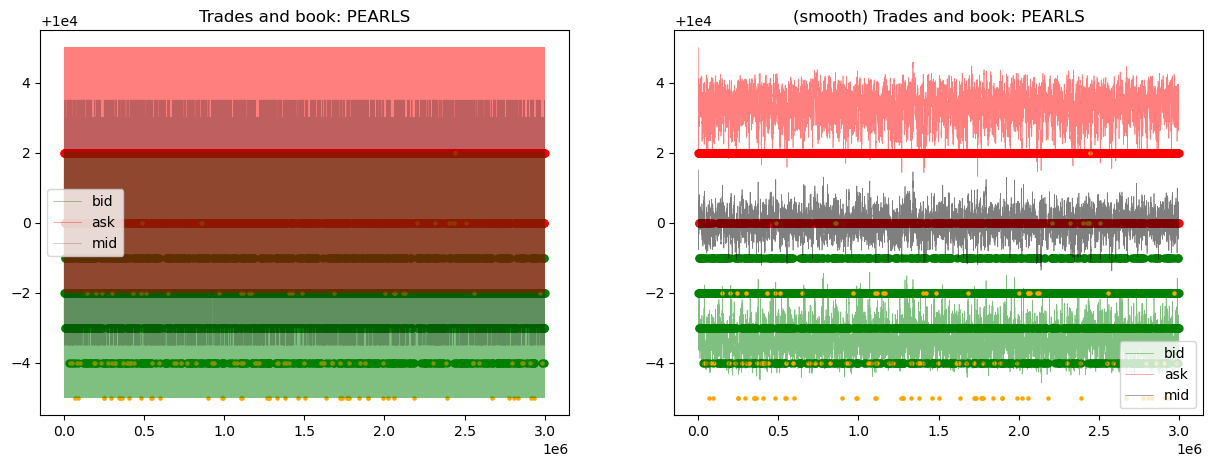

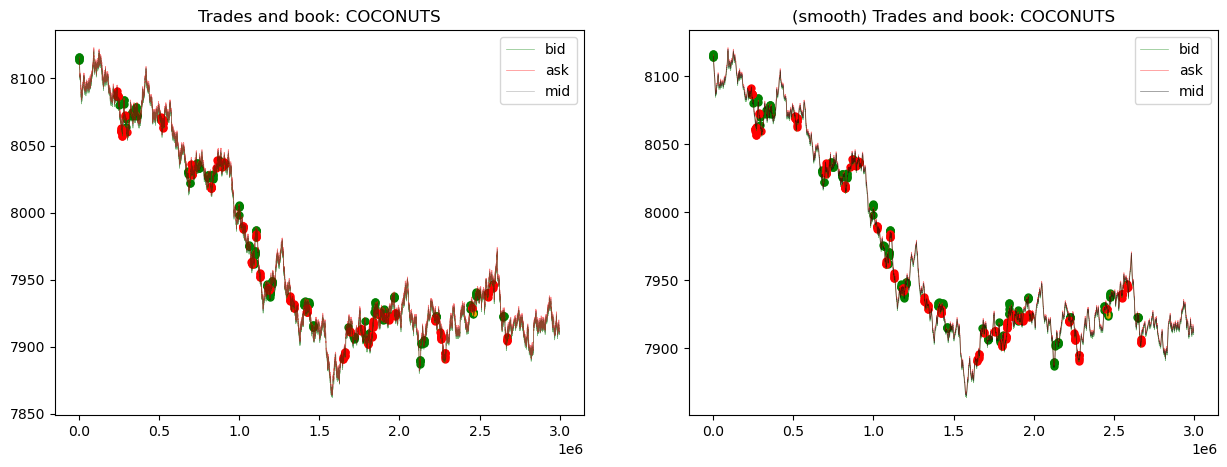

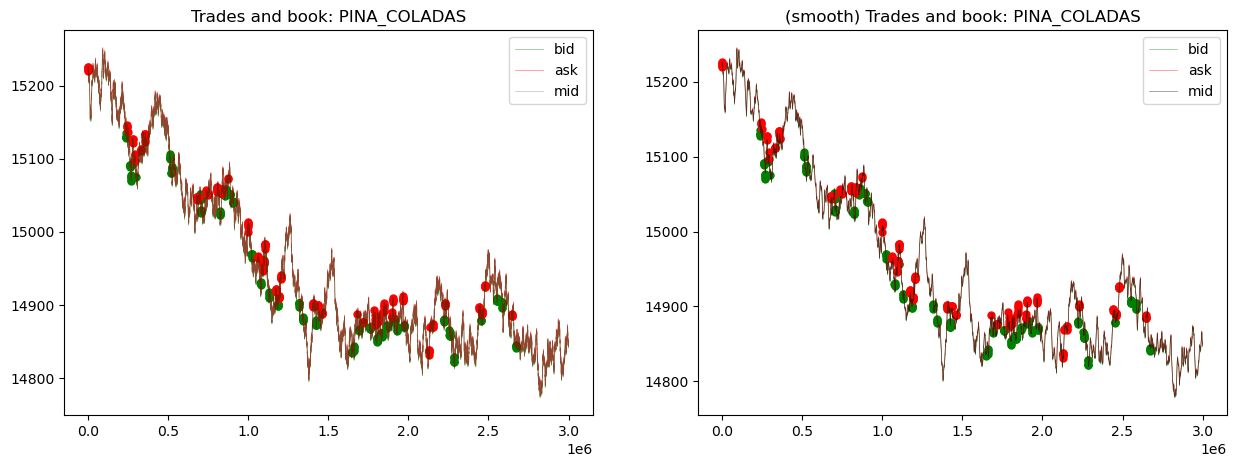

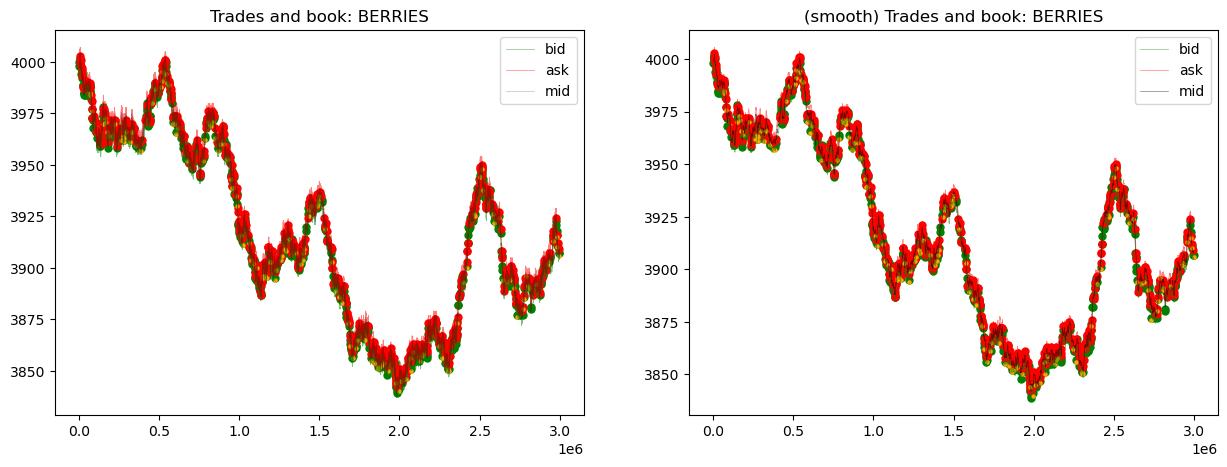

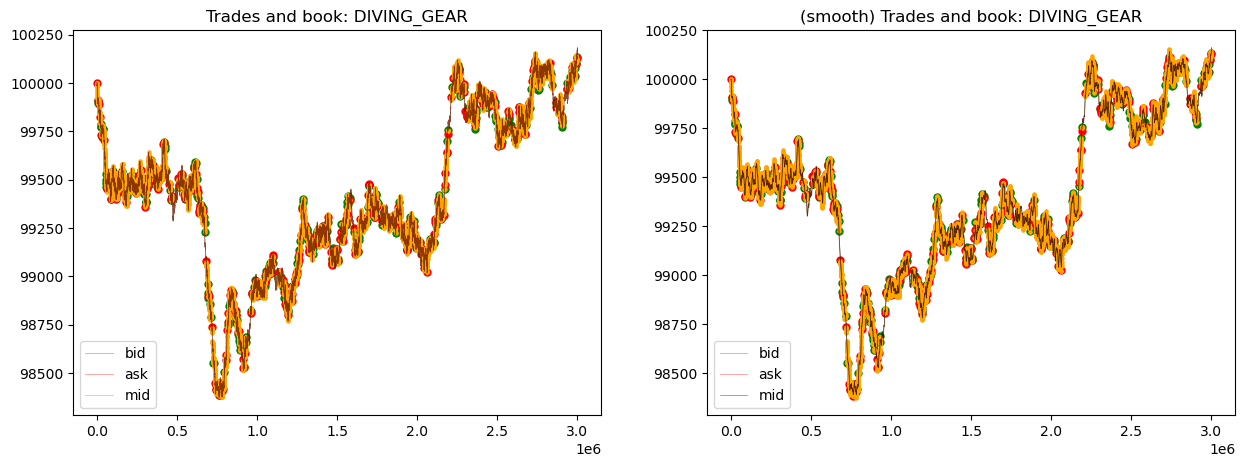

In [34]:
for sym in _symbols:
    plot_trades_and_book(
        sym=sym, 
        trade_df=trade_df, 
        book_df=book_tops, 
    #     time_lb=0, 
    #     time_ub=50000, 
        span=21,
        show_mid=True,
    )

### compare ref EMA to true EMA

In [35]:
symbol = "BANANAS"
spans = raw_records["best_ema_spans"].apply(lambda x : x[symbol])
spans.value_counts()

21     28132
100     1868
Name: best_ema_spans, dtype: int64

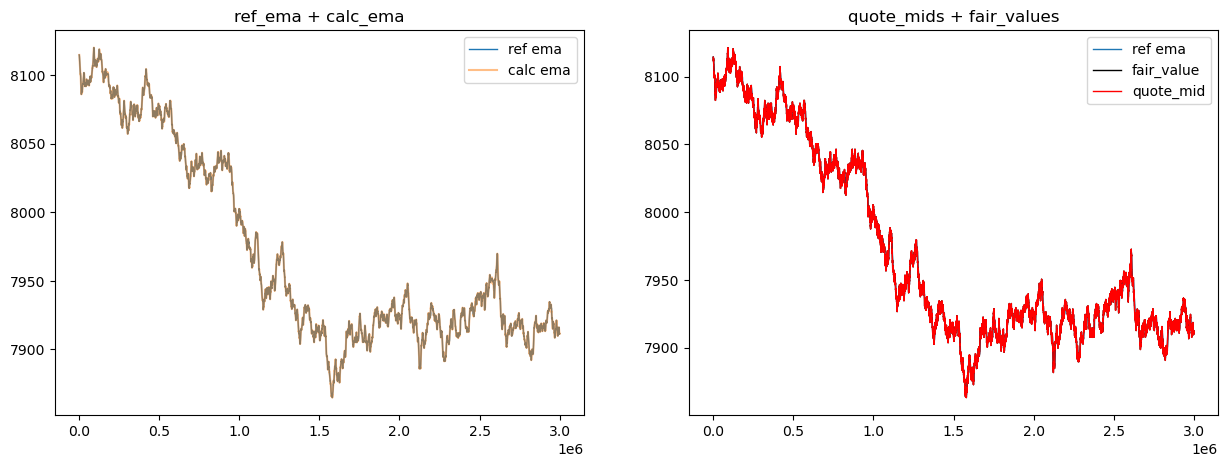

In [36]:
symbol = "COCONUTS"

mids = book_tops[f"{symbol}_mid"]
ema = mids.ewm(span=21).mean()

plt.figure(figsize=(15, 5))

plt.subplot(121)

plt.plot(ref_emas["time"], ref_emas[symbol], label="ref ema", alpha=1, linewidth=1)
plt.plot(book_tops["time"], ema, label="calc ema", alpha=0.5)
plt.legend()
plt.title("ref_ema + calc_ema")

plt.subplot(122)

plt.plot(ref_emas["time"], ref_emas[symbol], label="ref ema", alpha=1, linewidth=1)
plt.plot(fair_values["time"], fair_values[symbol], label="fair_value", color="black", alpha=1, linewidth=1)
plt.plot(quote_mids["time"], quote_mids[symbol], label="quote_mid", color="red", alpha=1, linewidth=1)
plt.legend()
plt.title("quote_mids + fair_values")
plt.show()


In [37]:
# print times when not using quote_mids
for sym in _symbols:
    print(sym, use_quote_mids[~use_quote_mids[sym]]["time"].tolist())


BANANAS [20700, 61100, 78800, 84200, 96100, 133200, 134800, 135800, 155700, 182200, 192500, 205400, 219200, 281400, 314200, 321800, 324800, 457400, 489700, 535800, 588100, 633200, 633800, 683700, 756700, 767900, 789100, 821700, 848000, 864100, 872600, 878200, 887200, 913100, 924100, 940600, 970700, 993900, 1006400, 1021000, 1030200, 1046600, 1054000, 1097000, 1122200, 1139800, 1158500, 1258200, 1313900, 1358200, 1375200, 1409200, 1445000, 1501000, 1504000, 1513800, 1544400, 1696900, 1798300, 1808000, 1814300, 1820400, 1855200, 1856800, 1884100, 1890700, 1894800, 1911000, 1943700, 1997600, 2094600, 2148700, 2204800, 2237400, 2256100, 2281700, 2356800, 2410700, 2431100, 2439400, 2449000, 2456400, 2463300, 2467100, 2471000, 2506400, 2514900, 2637200, 2664600, 2669400, 2700300, 2703000, 2736600, 2753100, 2760100, 2767500, 2785600, 2815800, 2846700, 2854600, 2919000, 2931900, 2935000, 2938700, 2966200, 2971300]
PEARLS [3700, 5600, 6100, 7000, 8300, 26600, 41300, 53800, 59900, 63500, 65300, 

### PNL Graph

Text(0.5, 1.0, 'PNL')

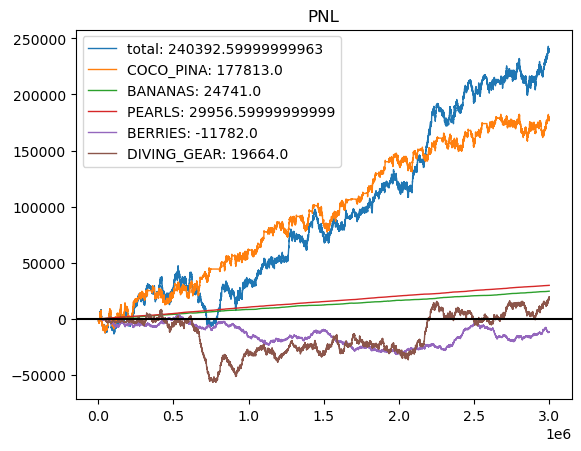

In [38]:
# pnl

# calc pnl from coco/pina pair
my_positions["COCO_PINA_pnl"] = my_positions["COCONUTS_pnl"] + my_positions["PINA_COLADAS_pnl"]

## shown products

products_shown = ["total", "COCO_PINA", "BANANAS", "PEARLS", "BERRIES", "DIVING_GEAR"]
# products_shown = ["total", *_products]

for prod in products_shown:
    pnl = my_positions[f"{prod}_pnl"].iloc[-1]
    plt.plot(my_positions["time"], my_positions[f"{prod}_pnl"], label=f"{prod}: {pnl}", linewidth=1)

plt.axhline(y=0, color="black")
    
plt.legend()
plt.title(f"PNL")


### Positions Graph

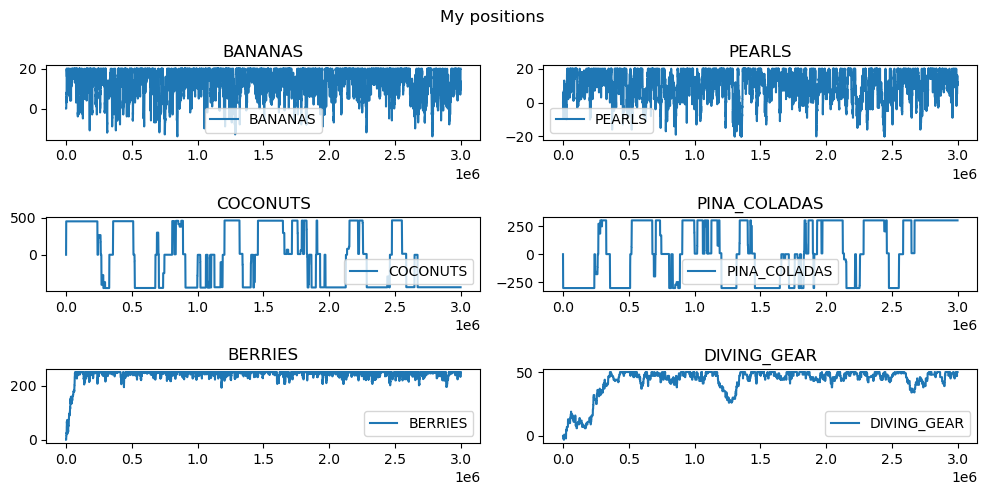

In [39]:
# plot my positions in each product

plt.figure(figsize=(10, 5))

for sym_i, sym in enumerate(_symbols):
    plt.subplot(3, 2, sym_i+1)
    plt.plot(my_positions["time"], my_positions[sym], label=sym)
    plt.title(sym)
    plt.legend()
    
    
plt.suptitle("My positions")
plt.tight_layout()
plt.show()

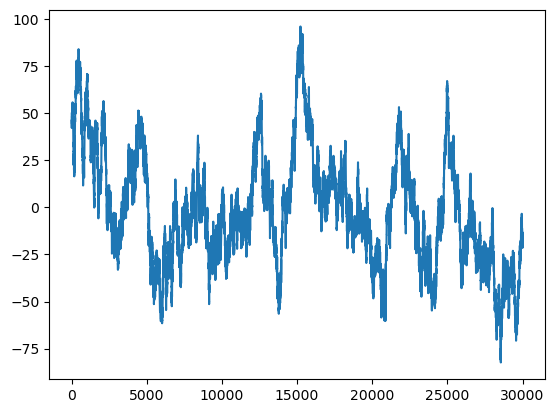

In [40]:
# plot pina_error (pina_actual - pina_pred)
model = np.poly1d([1.55131931e+00, 2.59237689e+03])

mid_df = book_tops[["COCONUTS_mid", "PINA_COLADAS_mid"]].copy()
mid_df["pred"] = model(mid_df["COCONUTS_mid"])
mid_df["pred_error"] = mid_df["PINA_COLADAS_mid"] - mid_df["pred"]

plt.plot(mid_df["pred_error"])
plt.show()

### Pina-coco error plot

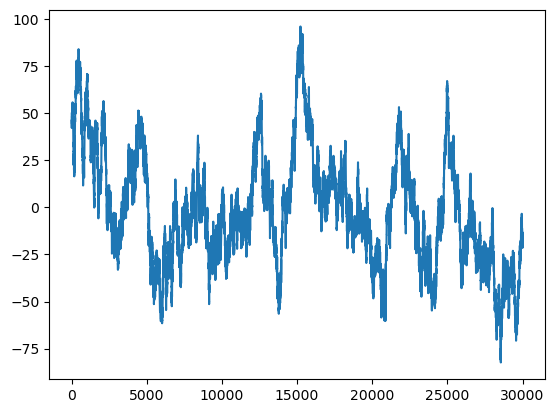

In [41]:
# plot pina_error (pina_actual - pina_pred)
model = np.poly1d([1.55131931e+00, 2.59237689e+03])

mid_df = book_tops[["COCONUTS_mid", "PINA_COLADAS_mid"]].copy()
mid_df["pred"] = model(mid_df["COCONUTS_mid"])
mid_df["pred_error"] = mid_df["PINA_COLADAS_mid"] - mid_df["pred"]

plt.plot(mid_df["pred_error"])
plt.show()

In [42]:
# pina-coco exposures
diffs = my_positions["PINA_COLADAS"] * 1.55 + my_positions["COCONUTS"]
diffs.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,30000.0,9.382222,14.848158,-15.0,-4.85,10.85,25.0,28.0


### Price movements (actual change)

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,29999.0,-0.003333,1.647155,-7.0,-1.0,0.0,1.0,6.5
PEARLS_mid,29999.0,-0.000117,2.111928,-7.0,-1.0,0.0,1.0,7.0
COCONUTS_mid,29999.0,-0.006767,0.896339,-4.0,-0.5,0.0,0.5,4.0
PINA_COLADAS_mid,29999.0,-0.012600,2.148053,-9.5,-1.5,0.0,1.5,9.5
BERRIES_mid,29999.0,-0.003050,1.060074,-5.0,-0.5,0.0,0.5,5.0
DIVING_GEAR_mid,29999.0,0.005984,6.219912,-26.0,-4.0,0.0,4.0,25.5


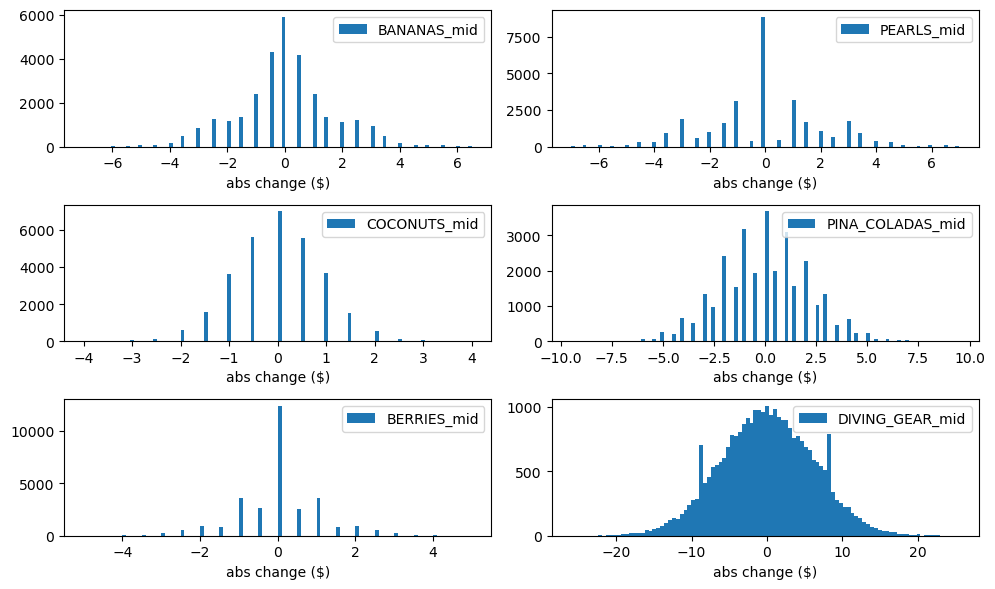

In [43]:
# distribution of price movements (pct change)

plt.figure(figsize=(10, 6))

mids = [f"{sym}_mid" for sym in _symbols]
cols = book_tops[mids]
diffs = (cols.shift(-1) - cols).dropna()

# show diffs stats
display(diffs.describe().T)


for sym_i, sym in enumerate(_symbols):
    
    mid = mids[sym_i]
    
    plt.subplot(3, 2, sym_i+1)

    plt.hist(diffs[mid], bins=100, label=mid)
    plt.xlabel("abs change ($)")
    plt.legend()
    
plt.tight_layout()
plt.show()


### Spread stats

BANANAS


,count,mean,std,min,25%,50%,75%,max
0,30000.0,5.203167,1.889076,1.0,5.0,6.0,7.0,7.0


PEARLS


,count,mean,std,min,25%,50%,75%,max
0,30000.0,6.7646,2.472743,2.0,6.0,8.0,8.0,10.0


COCONUTS


,count,mean,std,min,25%,50%,75%,max
0,30000.0,2.466567,0.610105,1.0,2.0,3.0,3.0,3.0


PINA_COLADAS


,count,mean,std,min,25%,50%,75%,max
0,30000.0,2.647433,0.589753,1.0,2.0,3.0,3.0,3.0


BERRIES


,count,mean,std,min,25%,50%,75%,max
0,30000.0,6.475467,1.228488,2.0,7.0,7.0,7.0,7.0


DIVING_GEAR


,count,mean,std,min,25%,50%,75%,max
0,30000.0,2.464667,0.52201,1.0,2.0,2.0,3.0,3.0


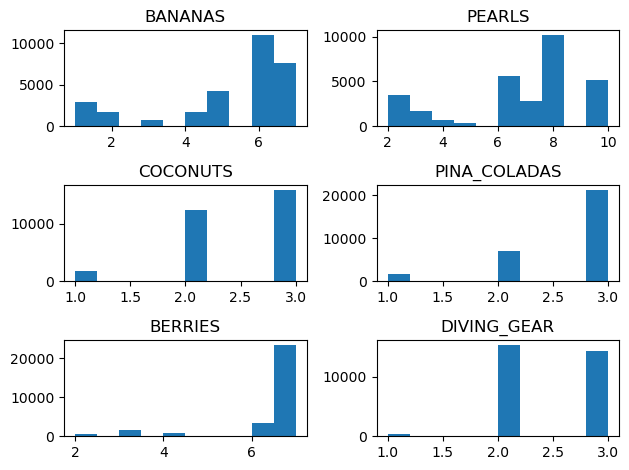

In [44]:
# spread summary stats

for sym_i, sym in enumerate(_symbols):
    print(sym)

    spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
    
    plt.subplot(3, 2, sym_i+1)
    plt.hist(spreads)
    plt.title(sym)
    display(spreads.describe().T)
    
plt.tight_layout()
plt.show()

In [45]:
# quantity stats
for sym in _symbols:
    df = trade_df[trade_df["symbol"] == sym]
    
    print(sym)
    display(df.groupby("time")[["quantity"]].sum().describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T)

BANANAS


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,6861.0,2.652675,3.168203,1.0,1.0,1.0,1.0,1.0,3.0,6.0,16.0,28.0


PEARLS


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,6478.0,2.535968,2.39767,1.0,1.0,1.0,1.0,1.0,3.0,6.0,11.0,19.0


COCONUTS


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,404.0,72.30198,45.632232,2.0,3.0,27.0,40.0,54.0,120.0,144.0,165.94,171.0


PINA_COLADAS


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,403.0,48.263027,30.423631,1.0,2.0,18.4,27.0,36.0,80.0,96.0,110.96,114.0


BERRIES


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,1720.0,7.122674,6.344351,1.0,1.0,1.0,2.75,5.0,10.0,16.0,28.0,38.0


DIVING_GEAR


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,11358.0,8.884135,11.223943,1.0,1.0,1.0,2.0,4.0,9.0,23.0,48.0,51.0


In [46]:
book_tops

,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,BERRIES_best_buy,BERRIES_best_sell,BERRIES_mid,BERRIES_spread,COCONUTS_best_buy,COCONUTS_best_sell,...,DIVING_GEAR_spread,PEARLS_best_buy,PEARLS_best_sell,PEARLS_mid,PEARLS_spread,PINA_COLADAS_best_buy,PINA_COLADAS_best_sell,PINA_COLADAS_mid,PINA_COLADAS_spread,time
turn,,,,,,,,,,,,,,,,,,,,,
0,4893.0,4899.0,4896.0,6.0,3997.0,4003.0,4000.0,6.0,8113.0,8116.0,...,2.0,9998.0,10005.0,10001.5,7.0,15225.0,15228.0,15226.5,3.0,0
1,4892.0,4896.0,4894.0,4.0,3996.0,4003.0,3999.5,7.0,8113.0,8115.0,...,2.0,9996.0,10002.0,9999.0,6.0,15223.0,15226.0,15224.5,3.0,100
2,4892.0,4899.0,4895.5,7.0,3995.0,4002.0,3998.5,7.0,8113.0,8116.0,...,1.0,9996.0,10004.0,10000.0,8.0,15226.0,15227.0,15226.5,1.0,200
3,4893.0,4899.0,4896.0,6.0,3995.0,4002.0,3998.5,7.0,8113.0,8115.0,...,2.0,9996.0,9998.0,9997.0,2.0,15224.0,15227.0,15225.5,3.0,300
4,4894.0,4899.0,4896.5,5.0,3996.0,4003.0,3999.5,7.0,8112.0,8114.0,...,3.0,9998.0,10004.0,10001.0,6.0,15220.0,15223.0,15221.5,3.0,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,4791.0,4798.0,4794.5,7.0,3904.0,3907.0,3905.5,3.0,7909.0,7911.0,...,3.0,9995.0,10005.0,10000.0,10.0,14842.0,14845.0,14843.5,3.0,2999500
29996,4792.0,4793.0,4792.5,1.0,3904.0,3911.0,3907.5,7.0,7909.0,7912.0,...,2.0,9995.0,10002.0,9998.5,7.0,14844.0,14847.0,14845.5,3.0,2999600
29997,4792.0,4799.0,4795.5,7.0,3904.0,3911.0,3907.5,7.0,7910.0,7913.0,...,3.0,9995.0,9998.0,9996.5,3.0,14844.0,14847.0,14845.5,3.0,2999700


In [47]:
book_top_df = book_tops.melt(id_vars=["time"])
cols = book_top_df["variable"].str.split("_", n=1).apply(pd.Series).set_axis(["symbol", "variable"], axis=1)

book_top_df = book_top_df.drop("variable", axis=1).join(cols)


In [48]:
book_top_df

,time,value,symbol,variable
0,0,4893.0,BANANAS,best_buy
1,100,4892.0,BANANAS,best_buy
2,200,4892.0,BANANAS,best_buy
3,300,4893.0,BANANAS,best_buy
4,400,4894.0,BANANAS,best_buy
...,...,...,...,...
719995,2999500,3.0,PINA,COLADAS_spread
719996,2999600,3.0,PINA,COLADAS_spread
719997,2999700,3.0,PINA,COLADAS_spread
719998,2999800,3.0,PINA,COLADAS_spread


###  taker vs maker stats

BANANAS - my TAKER pnl: 16117.920000000006


,count,mean,std,min,25%,50%,75%,max
my_edge,4826.0,1.544627,0.93444,-1.38,1.5,1.5,2.5,3.78


BANANAS - my MAKER pnl: 9753.21


,count,mean,std,min,25%,50%,75%,max
my_edge,2131.0,2.069282,0.45444,1.0,1.5,2.0,2.5,3.07


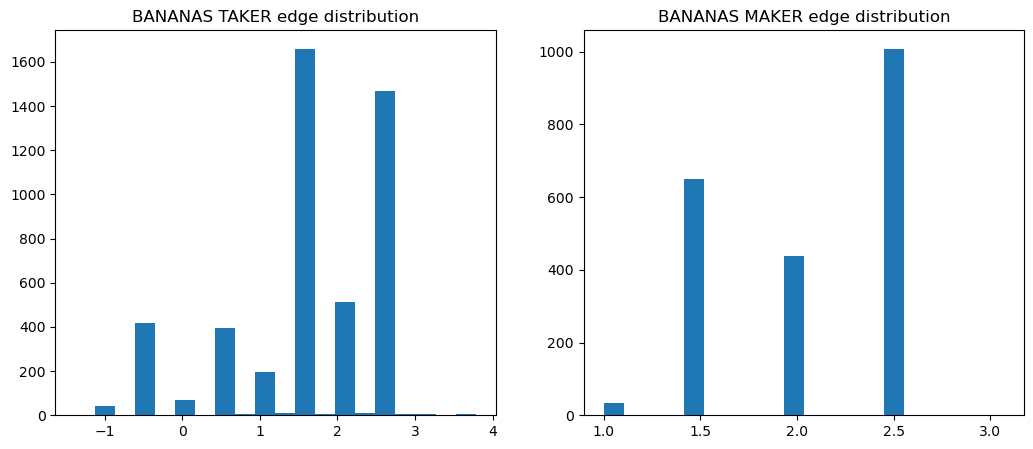

PEARLS - my TAKER pnl: 20724.530000000006


,count,mean,std,min,25%,50%,75%,max
my_edge,5225.0,1.736731,0.667352,-0.31,2.0,2.0,2.0,2.53


PEARLS - my MAKER pnl: 9159.19


,count,mean,std,min,25%,50%,75%,max
my_edge,1406.0,2.64463,1.140205,0.82,1.0,3.0,3.0,4.0


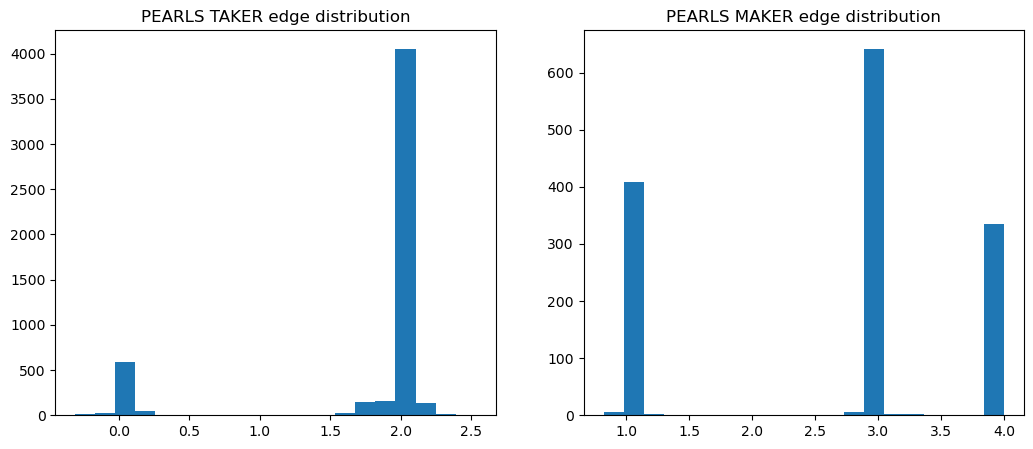

COCONUTS - my TAKER pnl: -35463.0


,count,mean,std,min,25%,50%,75%,max
my_edge,403.0,-1.081886,0.606347,-1.5,-1.5,-1.5,-0.5,0.5


COCONUTS - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


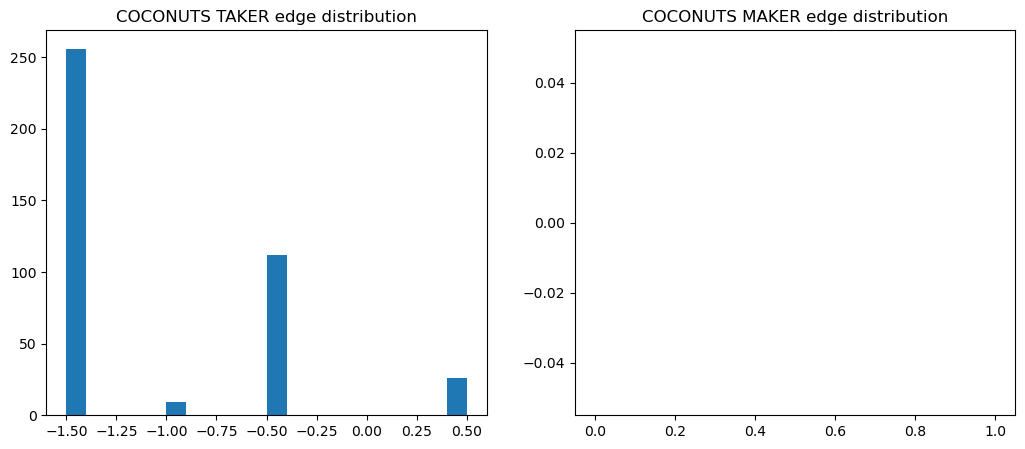

PINA_COLADAS - my TAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


PINA_COLADAS - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


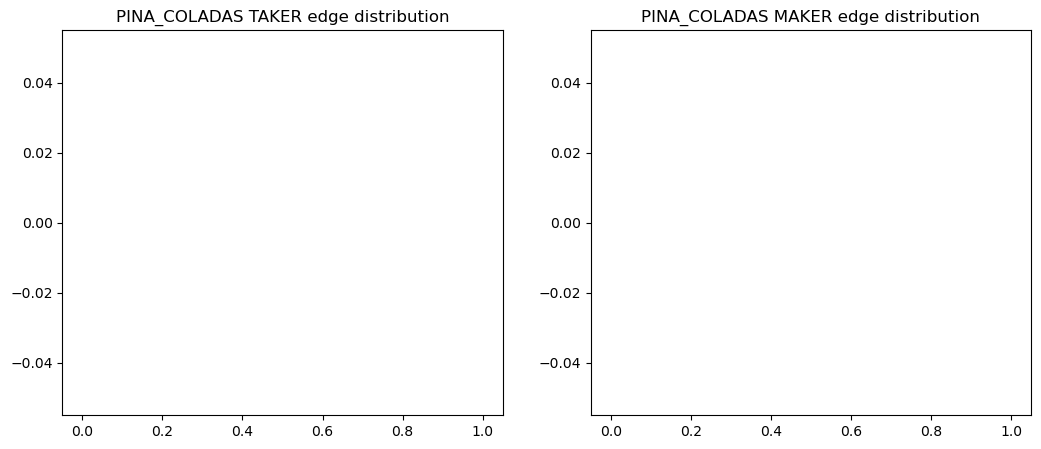

BERRIES - my TAKER pnl: 5073.5


,count,mean,std,min,25%,50%,75%,max
my_edge,1397.0,0.591983,0.445392,-0.0,0.5,0.5,0.5,1.5


BERRIES - my MAKER pnl: 5181.5


,count,mean,std,min,25%,50%,75%,max
my_edge,332.0,2.442771,0.173054,2.0,2.5,2.5,2.5,3.0


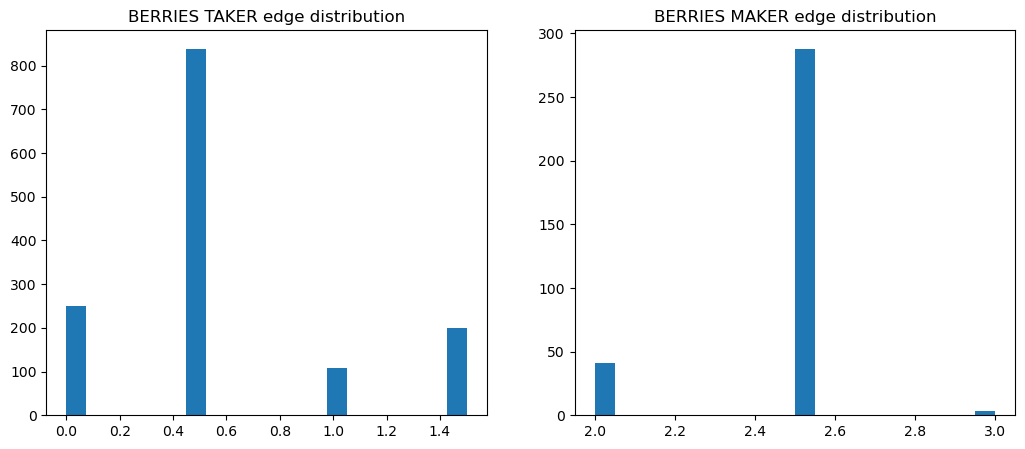

DIVING_GEAR - my TAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DIVING_GEAR - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


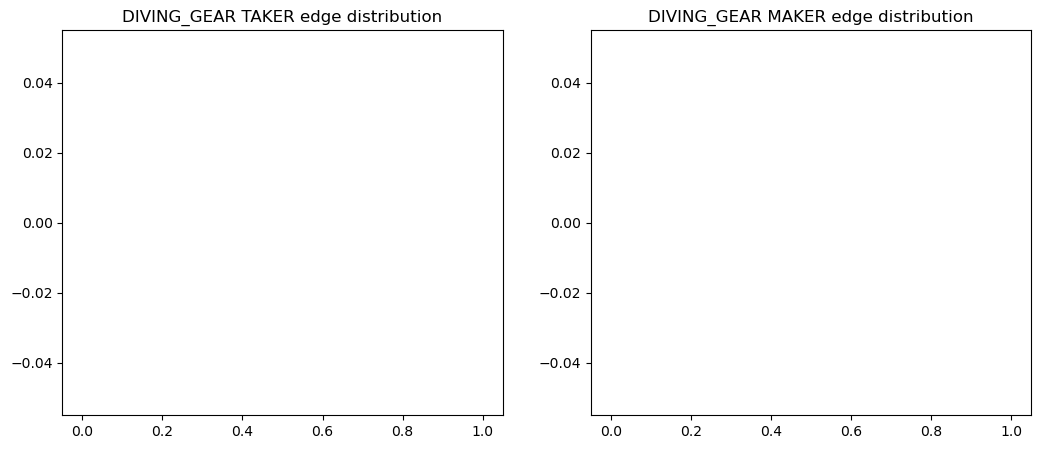

In [49]:
# merge current trades with previous turn's tops
my_trade_df = my_trades.copy()
my_trade_df["time"] -= _time_step

# get col to merge on
my_trade_df["variable"] = np.where(
    my_trade_df["my_buy"], 
    "best_sell", 
    "best_buy", 
)


my_trade_df = my_trade_df.merge(book_top_df, on=["time", "symbol", "variable"])

# if my buy price is greater than best sell price
# if my sell price is less than best buy price
my_trade_df["is_take"] = np.where(
    my_trade_df["my_buy"],
    my_trade_df["price"] >= my_trade_df["value"], # 
    my_trade_df["price"] <= my_trade_df["value"], # 
)


# drop cols
my_trade_df = my_trade_df.drop(["variable", "value"], axis=1)


# filter to keep only taker trades

# compute buy edge
my_trade_df["buy_edge"] = my_trade_df["fair_value"] - my_trade_df["price"]

# compute my edge
my_trade_df["my_edge"] = my_trade_df["buy_edge"] * np.sign(my_trade_df["my_quantity"])

# compute pnl
my_trade_df["pnl"] = my_trade_df["my_edge"] * my_trade_df["quantity"]

# filter by symbol
        
for sym in _symbols:
    the_df = my_trade_df[my_trade_df["symbol"] == sym]
    
    maker_df = the_df[~the_df["is_take"]]
    taker_df = the_df[the_df["is_take"]]
    

    # display pnl / stats for TAKER
    plt.figure(figsize=(12.5, 5))
    plt.subplot(121)
    print(sym, "- my TAKER pnl:", taker_df["pnl"].sum())

    display(taker_df[["my_edge"]].describe().T)

    plt.hist(taker_df[["my_edge"]], bins=20)
    plt.title(f"{sym} TAKER edge distribution")
    
    
    # display pnl / stats for MAKER
    plt.subplot(122)
    print(sym, "- my MAKER pnl:", maker_df["pnl"].sum())

    display(maker_df[["my_edge"]].describe().T)

    plt.hist(maker_df[["my_edge"]], bins=20)
    plt.title(f"{sym} MAKER edge distribution")
    plt.show()


### taker/maker optimization


- deciding whether to take/make:
    - current inventory (estimated)
    - common
        - cur_pos
    - taker:
        - info:
            - edge, quantity
        - actions
            - take all/ignore
            - take up to quantity
        - transition
            - reward = edge * abs(taken_quantity)
            - new_pos = cur_pos + taken_quantity
    - maker:
        - info:
            - edge (the edge that we'd receive for placing an order at the best bid)
            - limit
        - actions
            - quantity up to limit
            
        - transition
            - randomized taken_quantity is selected
            - reward = edge * abs(taken_quantity)
            - new_pos = cur_pos + taken_quantity
- state:
    - current inventory (

In [50]:
def rollout_action(cur_pos, limit, act):
    """
    Performs action given cur_pospotential action `act`
    
    Returns new_pos, pnl_change
    """
    
    edge = act["edge"]
    quantity = act["quantity"]
    is_buy = act["is_buy"]

    if edge == 0:
        # only take if it's good for us
        if is_buy:
            quantity = min(quantity, 0 - cur_pos)
        else:
            quantity = min(quantity, 0 + cur_pos)
    else:
        # take maximum
        if is_buy:
            quantity = min(quantity, limit - cur_pos)
        else:
            quantity = min(quantity, limit + cur_pos)

    # update state
    pnl_change = quantity * edge
    quantity_change = quantity if is_buy else -1 * quantity

    return cur_pos + quantity_change, pnl_change



### monte-carlo sim
def rollout(cur_pdf, limit, action_df):
    """
    Runs one MC rollout using the specified params
    
    Returns pnl_per_turn, ending_position
    """
    
    all_pdf = {i: 0 for i in range(-limit, limit + 1)}
    all_pnl = 0
    
    for cur_pos, cur_pos_prob in cur_pdf.items():
        if cur_pos_prob == 0:
            continue

        
        pdf = {i: 0 for i in range(-limit, limit + 1)}
        # if we don't take any taker_df trades, we will remain in this position
        pdf[cur_pos] = 1 - action_df["freq"].sum()

        # trade_pnl will contain expected pnl from trading when we start at 'cur_pos'
        trade_pnl = 0

        # iterate through actions
        for index, row in action_df.iterrows():
            new_pos, pnl_diff = rollout_action(cur_pos, limit, row)

            # get pnl from trade
            trade_pnl += pnl_diff * row["freq"]
            pdf[new_pos] += row["freq"]
            
        # pnl contains total profits from edge up to this point
#         print("trade pnl", cur_pos, trade_pnl)
        
        # update all_pnl
        all_pnl += trade_pnl * cur_pos_prob
        
        # update all_pdf
        for next_pos, next_pos_prob in pdf.items():
            all_pdf[next_pos] += next_pos_prob * cur_pos_prob
            
    return all_pnl, all_pdf

In [51]:
# hyper-params
def get_markov_chain(sym, limit, rollout_length):

    num_turns = _max_time / _time_step

    # create taker_df
    taker_df = order_df[order_df["symbol"] == sym]
    taker_df = taker_df[taker_df["taker_edge"] >= 0]
    taker_df = taker_df[["quantity", "taker_edge"]].copy().rename({"taker_edge": "edge"}, axis=1)

    taker_df["is_buy"] = ~(taker_df["quantity"] > 0) # we can perform the opposite trade against this quantity
    taker_df["quantity"] = taker_df["quantity"].abs()
    taker_df["edge"] = taker_df["edge"].abs() # convert -0 to 0

    # create order_df
    the_df = my_trade_df[(my_trade_df["symbol"] == sym)]
    maker_df = the_df[~the_df["is_take"]]
    maker_df = maker_df[["quantity", "my_edge", "my_buy"]].rename({"my_buy": "is_buy", "my_edge": "edge"}, axis=1)

    # calculate pnl
    taker_df["pnl"] = taker_df["edge"] * taker_df["quantity"]
    maker_df["pnl"] = maker_df["edge"] * maker_df["quantity"]

    # print stats abt taker/maker

    print("taker chance", len(taker_df) / num_turns)
    print("maker chance", len(maker_df) / num_turns)
    print("market_trade chance", len(market_trades) / num_turns)

    # print taker profits

    print("Taker total edge by side")
    display(taker_df.groupby("is_buy")["pnl"].sum())

    print("Maker total edge by side")
    display(maker_df.groupby("is_buy")["pnl"].sum())



    # calculate taker stats
    taker_stats = taker_df.groupby(["quantity", "edge", "is_buy"]).value_counts().rename("freq").reset_index()
    taker_stats["freq"] /= num_turns

    maker_stats = maker_df.groupby(["quantity", "edge", "is_buy"]).value_counts().rename("freq").reset_index()
    maker_stats["freq"] /= num_turns

    print("len(taker_stats)", len(taker_stats))
    print("len(maker_stats)", len(maker_stats))


    ## calculate transition matrices
    trade_pnls = {}
    next_pdfs = {}

    for cur_pos in range(-limit, limit + 1):
        # setup initial cur_pdf
        cur_pdf = {i: 0 for i in range(-limit, limit + 1)}
        cur_pdf[cur_pos] = 1

        # rollout on taker
        taker_pnl, pdf1 = rollout(
            cur_pdf=cur_pdf,
            limit=limit,
            action_df=taker_stats,
        )

        # rollout on maker
        maker_pnl, pdf2 = rollout(
            cur_pdf=pdf1,
            limit=limit,
            action_df=maker_stats,
        )

        trade_pnls[cur_pos] = taker_pnl + maker_pnl
        next_pdfs[cur_pos] = pdf2

    # get A - transition probability matrix
    # a_ij is prob of going from j to i
    trans_prob_df = pd.DataFrame(next_pdfs)
    A = trans_prob_df.to_numpy()

    # each row should sum to 1
    assert np.all(abs(A.sum(axis=0) - 1) <= 1e-5)

    # get D - transition income matrix
    trans_pnl_df = pd.DataFrame(trade_pnls.items(), columns=["cur_pos", "pnl"])
    trans_pnl_df = trans_pnl_df.sort_values(by="cur_pos")

    D = trans_pnl_df["pnl"].to_numpy()

    return A, D

In [52]:
# calculate scores
def score_matrix(A, D, limit):
    scores = {}

    for cur_pos in range(-limit, limit + 1):
        # init cur_pdf
        cur_pdf = np.zeros((2 * limit + 1, 1))
        cur_pdf[cur_pos + limit, 0] = 1

        pnl = 0

        # iterate for rollout number of times
        for i in range(rollout_length):
            trade_pnl = np.dot(D, cur_pdf).item()
            cur_pdf = A @ cur_pdf

            pnl += trade_pnl

        scores[cur_pos] = pnl
        
    score_df = pd.DataFrame(scores.items(), columns=["start_pos", "pnl"])
    score_df = score_df.set_index("start_pos")
    score_df["pnl_diff"] = score_df["pnl"] - score_df["pnl"].loc[0]
    score_df["pnl_diff_rev"] = list(score_df["pnl_diff"].iloc[::-1])
    score_df["pnl_norm"] = (score_df["pnl_diff_rev"] + score_df["pnl_diff"]) / 2
    
    return score_df

In [53]:
rollout_length = 100
limit = 20

In [54]:
# show scores for each position
sym = "BANANAS"

A, D = get_markov_chain(
    sym=sym,
    limit=limit,
    rollout_length=rollout_length,
)
score_df = score_matrix(A, D, limit=limit)

plt.plot(score_df.index, score_df["pnl_diff"], label="diff orig")
plt.plot(score_df.index, score_df["pnl_norm"], label="diff norm")
plt.legend()
plt.title(sym)
plt.show()

display(score_df)

# save to file
opp_costs = score_df["pnl_norm"].to_dict()

with open(f"./opp_costs_{sym}.json", "w") as f:
    f.write(str(opp_costs))

NameError: name 'order_df' is not defined

In [ ]:
# show scores for each position
sym = "PEARLS"

A, D = get_markov_chain(
    sym=sym,
    limit=limit,
    rollout_length=rollout_length,
)
score_df = score_matrix(A, D, limit=limit)

plt.plot(score_df.index, score_df["pnl_diff"], label="diff orig")
plt.plot(score_df.index, score_df["pnl_norm"], label="diff norm")
plt.legend()
plt.title(sym)
plt.show()

display(score_df)

# save to file
opp_costs = score_df["pnl_norm"].to_dict()

with open(f"./opp_costs_{sym}.json", "w") as f:
    f.write(str(opp_costs))

### Available Taker edge

In [ ]:
# calculate available taker edge

avail_taker_df = order_df[order_df["taker_edge"] > 0].copy()
avail_taker_df["pnl"] = avail_taker_df["taker_edge"] * avail_taker_df["quantity"].abs()

for sym in _symbols:
    df = avail_taker_df[avail_taker_df["symbol"] == sym]
    print(f"Available taker edge in {sym}", df["pnl"].sum().round())



### missed takers


In [ ]:

# get avail taker trades + my taker trades
avail_df = avail_taker_df
my_df = my_trade_df[my_trade_df["is_take"]]

# filter columns
my_df = my_df[["time", "symbol", "price", "my_quantity"]]
avail_df = avail_df[["time", "symbol", "price", "quantity", "taker_edge", "fair_value"]]

# see which avail taker trades were actually taken by me
taker_df = avail_df.merge(my_df, how="left", on=["time", "symbol", "price"])

taker_df["my_quantity"] = taker_df["my_quantity"].fillna(0)

# ensure my_quantity is not the same sign of resting order quantity
wrongs = (taker_df["my_quantity"] == taker_df["quantity"])
assert(wrongs.sum() == 0)
# display(taker_df[wrongs])

# calculate taken vs avail size
taker_df["avail_size"] = taker_df["quantity"].abs()
taker_df["taken_size"] = np.minimum(taker_df["my_quantity"].abs(), taker_df["avail_size"])
taker_df["missed_size"] = taker_df["avail_size"] - taker_df["taken_size"]

# calculate taken vs avail pnl
taker_df["avail_pnl"] = taker_df["taker_edge"] * taker_df["avail_size"]
taker_df["taken_pnl"] = taker_df["taker_edge"] * taker_df["taken_size"]
taker_df["missed_pnl"] = taker_df["taker_edge"] * taker_df["missed_size"]

for sym in _symbols:
    df = taker_df[taker_df["symbol"] == sym]
    
    print(sym, "taken_pnl", df["taken_pnl"].sum())
    print(sym, "avail_pnl", df["avail_pnl"].sum())
    print(sym, "missed_pnl", df["missed_pnl"].sum())
    print()
    print(sym, "taken_size", df["taken_size"].sum())
    print(sym, "avail_size", df["avail_size"].sum())
    print(sym, "missed_size", df["missed_size"].sum())
    print()


In [ ]:
# missed takers
my_pos_df = my_positions.melt(id_vars=["time"], value_vars=_symbols, var_name="symbol", value_name="cur_pos")

untaken_df = taker_df[taker_df["avail_size"] != taker_df["taken_size"]]

# untaken_df = untaken_df[["time", "symbol", "price", "fair_value", "taker_edge", "avail_size", "taken_size"]].merge(my_pos_df, on=["time", "symbol"])
untaken_df = untaken_df.merge(my_pos_df, on=["time", "symbol"])

for sym in _symbols:
    df = untaken_df[untaken_df["symbol"] == sym].drop(["my_quantity"], axis=1)
    
    display(df)
    
    

### Available maker edge

In [ ]:
# calculate market maker edge (maker edge that the market received)
maker_df = market_trades.copy()

maker_df["edge"] = maker_df["buy_edge"].abs()
maker_df["pnl"] = maker_df["quantity"] * maker_df["edge"]

for sym in _symbols:
    df = maker_df[maker_df["symbol"] == sym]
    print(f"Remaining maker edge in {sym}", df["pnl"].sum().round())
    

## Trade analysis - BANANAS

#### func - calc_rtns()

In [ ]:
# find performance of trades after 1 tick, 10 ticks, 100 ticks
# returns only my trades for the specified symbol
def calc_rtns(trade_df, sym, waits):
    global fairs
    
    df = trade_df
    df = df[df["symbol"] == sym]
    df = df[df["is_me"]]

    for wait in waits:
        suffix = f"_{wait}"

        # get shifted fairs
        fairs_shift = fairs.set_index("time").shift(-1 * wait).ffill().bfill().add_suffix(suffix)
        fairs_shift = fairs_shift.reset_index()

        df = pd.merge(df, fairs_shift)

    for wait in waits:
        df[f"rtn_{wait}"] = (df[f"{sym}_{wait}"] - df["price"]) * np.sign(df["my_quantity"])

    return df



#### func - blur()

In [ ]:
def blur(df, mu=0, std=0.1):
    noise = np.random.normal(loc=mu, scale=std, size=df.shape)
    return df + noise

### Rtn over time

In [ ]:
# summary stats for trades vs rtns

sym = "BANANAS"
waits=[-1, 0, 1, 3, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])
plt.title("rtn_0")

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total profit", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

### rtn vs quantity graph

In [ ]:
plt.scatter(blur(df["quantity"], std=0.1), blur(df["rtn_0"], std=0.1), s=5, label="rtn_10")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



### large trades

In [ ]:
# print out large trades

sizes = df.groupby("time")[["quantity"]].sum()
big_days = sizes[sizes["quantity"] >= 15]
df[df["time"].isin(big_days.index)]

### losers: trade/book graph

In [ ]:
losers = df[(df["rtn_10"] < 0)]
winners = df[df["rtn_10"] > 0]

In [ ]:
plot_trades_and_book(
    sym="BANANAS", 
    trade_df=pd.concat([losers, market_trades], axis=0), 
    book_df=book_tops, 
    time_lb=0, 
    time_ub=2e5, 
    span=10,
    show_mid=True,
)


In [ ]:
losers

## Trade analysis - PEARLS

### rtn over time

In [ ]:
### summary stats for trades vs rtns

sym = "PEARLS"
waits=[-1, 0, 1, 3, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total prof", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

### rtn vs quantity graph

In [ ]:
plt.scatter(blur(df["quantity"], std=0.0), blur(df["rtn_0"], std=0.1), s=5, label="rtn_0")
# plt.scatter(blur(df["quantity"]), blur(df["rtn_100"]), s=5, label="rtn_100")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



### losers: rtn0 vs spread

In [ ]:
losers = df[(df["rtn_0"] < 0)]
winners = df[df["rtn_0"] > 0]

df = pd.merge(losers, book_tops[["BANANAS_spread", "time"]].shift(1), on="time")
plt.scatter(blur(df["BANANAS_spread"]), blur(df["rtn_0"]), s=5)

In [ ]:
losers.describe().T

### losers: histogram of price changes

In [ ]:
loser_diffs = (abs(losers["PEARLS_-1"] - losers["PEARLS_0"]))

plt.hist(loser_diffs)

### losers: trade/book graph

In [ ]:
plot_trades_and_book(
    sym="PEARLS", 
    trade_df=pd.concat([losers, market_trades], axis=0), 
    book_df=book_tops, 
    time_lb=0, 
    time_ub=100000, 
    span=21,
    show_mid=True,
)
